### Deep Reinforcement Learning-based Image Captioning with Embedding Reward
Originally made by Pranshu Gupta, Deep Learning @ Georgia Institute of Technology

In [12]:
torch.cuda.empty_cache()

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import nltk
import random

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional as F

from utils.bleu_torch import bleu_score
from utils.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from utils.image_utils import image_from_url
from models.nets import PolicyNetwork, RewardNetwork, ValueNetwork
from search.search import GenerateCaptions, GenerateCaptionsWithBeamSearch
from torchsummary import summary
import metrics

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Working on: ", device)

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

max_seq_len = 17

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

Working on:  cuda


### Load MS-COCO data

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

data["train_captions_lens"] = np.zeros(data["train_captions"].shape[0])
data["val_captions_lens"] = np.zeros(data["val_captions"].shape[0])
for i in range(data["train_captions"].shape[0]):
    data["train_captions_lens"][i] = np.nonzero(data["train_captions"][i] == 2)[0][0] + 1
for i in range(data["val_captions"].shape[0]):
    data["val_captions_lens"][i] = np.nonzero(data["val_captions"][i] == 2)[0][0] + 1


# Print out all the keys and values from the data dictionary
# for k, v in data.items():
#     if type(v) == np.ndarray:
#         print(k, type(v), v.shape, v.dtype)
#     else:
#         print(k, type(v), len(v))

In [3]:
small_data = load_coco_data(max_train=50000)

### Caption Evaluation Functions

In [4]:
def BLEU_score(gt_caption, sample_caption, w):
    """
    gt_caption: string, ground-truth caption
    sample_caption: string, your model's predicted caption
    Returns unigram BLEU score.
    """
    try: 
        reference = [x for x in gt_caption.split(' ') 
                     if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
        hypothesis = [x for x in sample_caption.split(' ') 
                      if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
        
    except AttributeError:
        reference = [x for x in gt_caption
                     if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
        hypothesis = [x for x in sample_caption
                      if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
        
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [w])
    return BLEUscore

def BLEU_tensor(captions_in, target_caption):
    idx_to_word = {i : w for w, i in data["word_to_idx"].items()}
    source = []
    target = []
    
    for i in range(captions_in.shape[1]):
        source.append(idx_to_word[captions_in[0][i].item()])
        
    for i in range(target_caption.shape[1]):
        target.append(idx_to_word[target_caption[0][i].item()])
    
    b1 = BLEU_score(source, target,1)
    b2 = BLEU_score(source, target,2)
    b3 = BLEU_score(source, target,3)
    b4 = BLEU_score(source, target,4)
    return 0.5 * b1 + 0.5 * b2 + b3 + b4

def evaluate_model(model):
    """
    model: CaptioningRNN model
    Prints unigram BLEU score averaged over 1000 training and val examples.
    """
    BLEUscores = {}
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(data, split=split, batch_size=1000)
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])

        sample_captions = model.sample(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))
        
# ref, hypo = metrics.load_textfiles(tru_caps, gen_caps)
# print(metrics.score(ref, hypo))

### Training Baseline (Trained only on BLEU)

In [5]:
# baseline = RewardNetwork(data["word_to_idx"]).to(device)
# baseline.load_state_dict(torch.load('./pretrained/rewardNetwork_pre.pt')
class BaselineNetwork(nn.Module):
    def __init__(self, word_to_idx, batch_size=10, wordvec_dim=512):
        super().__init__()
        vocab_size = len(word_to_idx)
        self.batch_size = batch_size
        self.caption_embedding = nn.Embedding(vocab_size, wordvec_dim)
        
        self.scoring1 = nn.Linear(16 * 512, 512)
        self.scoring2 = nn.Linear(512, 1)
        
    def forward(self, captions, train=True):
        
        input_captions = self.caption_embedding(captions)
        if train == False:
            margin = torch.zeros(1, 16 - input_captions.shape[1], 512).to(device)
            input_captions = torch.cat((input_captions, margin), dim=1)
            input_captions = input_captions.view(1, -1)
          
        else:
            margin = torch.zeros(self.batch_size, 16 - input_captions.shape[1], 512).to(device)
            input_captions = torch.cat((input_captions, margin), dim=1)
            input_captions = input_captions.view(self.batch_size, -1)
        output = self.scoring1(input_captions)
        output = self.scoring2(output)
        output = output.squeeze(1)
        return output

baseline = BaselineNetwork(data["word_to_idx"]).to(device)

In [6]:
# policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
# policyNet.load_state_dict(torch.load('./pretrained/policyNetwork_pre2.pt'))
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(baseline.parameters(), lr=0.001)

caps0 = []
caps1 = []

f = open("./results/truth3.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    caps0.append(x)
f = open("./results/greedy3.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    caps1.append(x)

In [9]:
epochs = 10000
bestLoss = 10
batch_size = 10

baseline.train()
for epoch in range(epochs):
    caps = []
    bs = []
    
    i = epoch
    for _ in range(batch_size):
        i %= len(caps0)
        b1 = BLEU_score(caps0[i], caps1[i], 1)
        b2 = BLEU_score(caps0[i], caps1[i], 2)
        b3 = BLEU_score(caps0[i], caps1[i], 3)
        b4 = BLEU_score(caps0[i], caps1[i], 4)
        b = 0.5 * b1 + 0.5 * b2 + b3 + b4
        bs.append(b)
        
        cap = caps1[i].split()
        for j in range(len(cap)):
            cap[j] = data["word_to_idx"][cap[j]]
        while(len(cap) < 16):
            cap.append(0)
        
        caps.append(cap)
        i += 1
        
    caps = torch.tensor(caps).to(device)
    bs = torch.tensor(bs).to(device)
    
    output = baseline.forward(caps)
    if (epoch == epochs - 1):
        print(output, bs)
    print(loss.item())
    loss = criterion(output, bs)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if loss.item() < bestLoss or (epoch == epochs-1 and bestLoss == 10):
        bestLoss = loss.item()
        torch.save(baseline.state_dict(), "./pretrained/baseline_pre.pt")
        print("Best! epoch:", epoch, "loss:", loss.item())

NameError: name 'baseline' is not defined

## Reinforcement Learning
Advantage Actor Critic Model for Reinforcement Learning

In [7]:
class AdvantageActorCriticNetwork(nn.Module):
    def __init__(self, valueNet, policyNet):
        super(AdvantageActorCriticNetwork, self).__init__()

        self.valueNet = valueNet #RewardNetwork(data["word_to_idx"]).to(device)
        self.policyNet = policyNet #PolicyNetwork(data["word_to_idx"]).to(device)

    def forward(self, features, captions):
        # Get value from value network
        values = self.valueNet(features, captions)
        # Get action probabilities from policy network
        probs = self.policyNet(features.unsqueeze(0), captions)[:, -1:, :]        
        return values, probs 

In [8]:
policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
valueNet = ValueNetwork(data["word_to_idx"]).to(device)
baseline = BaselineNetwork(data["word_to_idx"]).to(device)

if (os.path.exists('./pretrained/policyNetwork_pre2.pt')):
    policyNet.load_state_dict(torch.load('./pretrained/policyNetwork_pre2.pt'))
    print("policy pre2 loaded")
else:
    policyNet.load_state_dict(torch.load('./pretrained/policyNetwork_pre.pt'))

if (os.path.exists('./pretrained/valueNetwork_pre2.pt')):
    valueNet.load_state_dict(torch.load('./pretrained/valueNetwork_pre2.pt'))
    print("valid pre2 loaded")
else:
    valueNet.load_state_dict(torch.load('./pretrained/valueNetwork_pre.pt'))

baseline.load_state_dict(torch.load('./pretrained/baseline_pre.pt'))
    
a2cNetwork = AdvantageActorCriticNetwork(valueNet, policyNet)
optimizer = optim.Adam(a2cNetwork.parameters(), lr=0.0001)

policy pre2 loaded
valid pre2 loaded


### Curriculum Learning

In [9]:
a = torch.tensor(3)
word_to_idx = {w : i for i, w in data["word_to_idx"].items()}
b = word_to_idx[a.item()]
print(b)

<UNK>


In [13]:
episodes = 50
epochs = 20 #1000 but out of memory...
small_data = load_coco_data(max_train=50000)
bestLoss = 1.0
optimizer = optim.Adam(a2cNetwork.parameters(), lr=0.0001)
word_to_idx = {w : i for i, w in data["word_to_idx"].items()}


baseline.train()
policyNet.train()
for epoch in range(epochs): 
    episodicAvgLoss = 0

    captions, features, _ = sample_coco_minibatch(small_data, batch_size=episodes, split='train')
    features = torch.tensor(features, device=device).float() 
    captions = torch.tensor(captions, device=device).long()
    
    for episode in range(episodes):
        log_probs = []
        values = []
        rewards = []
        caplen = np.nonzero(captions[episode] == 2)[0][0] + 1
        gen_cap = 0
        

        captions_in = captions[episode:episode+1, :2]
        features_in = features[episode:episode+1]

        value, probs = a2cNetwork(features_in, captions_in)
        
        while(captions_in.shape[1] < 16 and gen_cap != 2): #Generate Sequence g1:T 

            value, probs = a2cNetwork(features_in, captions_in)
            probs = F.softmax(probs, dim=2)

            dist = probs.cpu().detach().numpy()[0,0]
            action = np.random.choice(probs.shape[-1], p=dist)
            
            gen_cap = torch.from_numpy(np.array([action])).unsqueeze(0).to(device)
            captions_in = torch.cat((captions_in, gen_cap), axis=1)
            
        
        len_caption = captions_in.shape[1]

        loss_V = 0
        loss_L = 0
        for t in range(len_caption):  # Compute the Q and B for every t in range from 1 to T
            captions_in = captions[episode:episode+1, : t+1]
            captions_in2 = captions[episode:episode+1, : t+1]
            captions_in3 = captions[episode:episode+1, : t+1]

            features_in = features[episode:episode+1]
            b = baseline.forward(captions_in, train=False)
            gen_cap = 0
            first = 1

            while(captions_in.shape[1] < 16 and gen_cap != 2): #Generate Sequence g1:T  for calculating Q
                
                value, probs = a2cNetwork(features_in, captions_in)

                probs = F.softmax(probs, dim=2)
                
                dist = probs.cpu().detach().numpy()[0,0]
                action = np.random.choice(probs.shape[-1], p=dist)
                action2 = np.random.choice(probs.shape[-1], p=dist)
                action3 = np.random.choice(probs.shape[-1], p=dist)

                gen_cap = torch.from_numpy(np.array([action])).unsqueeze(0).to(device)
                gen_cap2 = torch.from_numpy(np.array([action2])).unsqueeze(0).to(device)
                gen_cap3 = torch.from_numpy(np.array([action3])).unsqueeze(0).to(device)

                captions_in = torch.cat((captions_in, gen_cap), axis=1)
                captions_in2 = torch.cat((captions_in2, gen_cap2), axis=1)
                captions_in3 = torch.cat((captions_in3, gen_cap3), axis=1)

                if(first == 1):
                    first = 0
                    p = probs[0, 0, action]

    
            target_caption = captions[episode:episode+1]
            

            q = BLEU_tensor(captions_in, target_caption) # 1から4の配合忘れんように
            q += BLEU_tensor(captions_in2, target_caption)
            q += BLEU_tensor(captions_in3, target_caption)
            q /= 3.0
            
            print(p, q, b[0])
            if (first == 1): continue
            loss_V += (p * (q - b[0]))
            loss_L += (q - b[0])**2
        
        loss = loss_V + loss_L
        
        episodicAvgLoss += loss.item()/episodes

        # baseline.eval()
        # policyNet.train()
        optimizer.zero_grad()
        loss_V.backward(retain_graph=True)
        optimizer.step()

        # baseline.train()
        # policyNet.eval()
        optimizer.zero_grad()
        loss_L.backward(retain_graph=True)
        optimizer.step()

    print("epoch:", epoch, episodicAvgLoss)

torch.save(policyNet.state_dict(), "./pretrained/policyNetwork_final.pt")
torch.save(baseline.state_dict(), "./pretrained/BaselineNetwork_final.pt")

print("Models are saved")

a:0', grad_fn=<SelectBackward>) 0.3542139349587228 tensor(0.0962, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0002, device='cuda:0', grad_fn=<SelectBackward>) 0.3897201556028917 tensor(0.1325, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0778, device='cuda:0', grad_fn=<SelectBackward>) 0.5794906045065386 tensor(0.1754, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0916, device='cuda:0', grad_fn=<SelectBackward>) 0.760027012409893 tensor(0.1948, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0960, device='cuda:0', grad_fn=<SelectBackward>) 0.8980286645244991 tensor(0.1533, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.5951, device='cuda:0', grad_fn=<SelectBackward>) 1.254351160026596 tensor(0.1253, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0279, device='cuda:0', grad_fn=<SelectBackward>) 1.4596328589044871 tensor(0.1363, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0042, device='cuda:0', grad_fn=<SelectBackward>) 1.8299397157114885 tensor

In [18]:
#Testing
a = torch.tensor([[1,2,3]])
b = torch.tensor([1])
for i,j in zip(a,b):
    print(i,j)

tensor([1, 2, 3]) tensor(1)


## Final Evaluation

In [14]:
policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
policyNet.load_state_dict(torch.load('./pretrained/policyNetwork_final.pt'))
valueNet = ValueNetwork(data["word_to_idx"]).to(device)
valueNet.load_state_dict(torch.load('./pretrained/valueNetwork_final.pt'))

[autoreload of six failed: Traceback (most recent call last):
  File "/home/wkawabe/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/wkawabe/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/wkawabe/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/wkawabe/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 287, in update_class
    old_obj = getattr(old, key)
  File "/home/wkawabe/.local/lib/python3.6/site-packages/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]


<All keys matched successfully>

In [15]:
with open('results/policyvalue4.txt', 'w'):
    pass
with open('results/truth4.txt', 'w'):
    pass

Truth   :  <START> an image of a bear that is in the woods <END>
Output:  <START> two <UNK> animals are swimming pool animal painted black dog laying down train tracks <END>
Truth   :  <START> a person on a court with a tennis racket <END>
Output:  <START> a kid jumps into the air his racket hard wood floors stand there are remote controllers
Truth   :  <START> the <UNK> sink counter of the bathroom has a flower vase on it <END>
Output:  <START> a bathroom area contains a nice concrete hotel room doing work containing dish among other assorted
Truth   :  <START> a picture of a statue of a man with a <UNK> <END>
Output:  <START> a smiling woman dish dish from an oven cheese sauce pizza is docked out the table
Truth   :  <START> a zebra <UNK> across a dirt road in the <UNK> of <UNK> <END>
Output:  <START> a single zebra walking bed together in uniform herd of down wild giraffe walking away from
Truth   :  <START> a <UNK> view of a clean white toilet in the image <END>
Output:  <START> a 

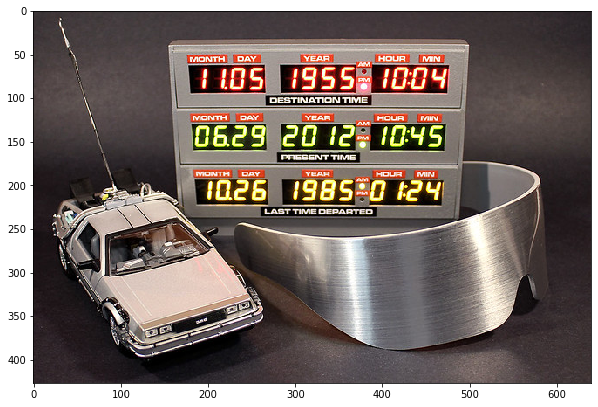

In [18]:
num_of_sentences = 150

with torch.no_grad():
    max_seq_len = 17
    captions, features, urls = sample_coco_minibatch(small_data, batch_size=1000, split='val')
    gen_caps = []
    tru_caps = []
    with open('results/policyvalue4.txt', mode='w') as f:
        with open('results/truth4.txt', mode='w') as f2:
            count = 0
            
            for i in range(num_of_sentences):
                try:    #pass if the url doesnt exist
                    plt.imshow(image_from_url(urls[i]))
                    count += 1
                except:
                    continue
                if count >= 101: 
                    break 
                decoded_tru_caps = decode_captions(captions[i], data["idx_to_word"])
                gen_cap = GenerateCaptions(features[i:i+1], captions[i:i+1], policyNet)[0]
                decoded_gen_caps = decode_captions(gen_cap, data["idx_to_word"])


                f.writelines(' '.join(decoded_gen_caps))
                f.write('\n')

                f2.writelines(' '.join(decoded_tru_caps))
                f2.write('\n')
                
                print("Truth   : ", decoded_tru_caps) 
                print("Output: ", decoded_gen_caps) 

In [19]:
tru_caps = []
gen_caps = []

f = open("./results/truth4.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    tru_caps.append(x)
    
f = open("./results/policyvalue4.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    gen_caps.append(x)

In [20]:
bleu = 0
for w in range(1, 5):
    for i in range(len(tru_caps)):

        bleu += BLEU_score(tru_caps[i], gen_caps[i], w)
        bleu /= len(tru_caps)

    print("BLEU-" + str(w), ":", bleu)

BLEU-1 : 0.0066115510400149334
BLEU-2 : 0.004328001181317262
BLEU-3 : 0.002833430778416446
BLEU-4 : 0.0018551378706136463


In [21]:
ref, hypo = metrics.load_textfiles(tru_caps, gen_caps)
print(metrics.score(ref, hypo))

The number of references is 100
{'ROUGE_L': 0.5255603050794995, 'CIDEr': 0.08223672396571315}
